In [ ]:
pip install spotipy

In [ ]:
pip install mysql-connector-python

# Database

Let's create and connect to a database

In [8]:
import sqlite3

database = sqlite3.connect('spotify.db')

Let's create a table for our streaming history

In [9]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS streaming_history(
                    endTime DATETIME,
                    artistName varchar(40),
                    trackName varchar(40),
                    msPlayed int,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

Now let's insert our streaming history JSON into the database.

In [10]:
import json

def getData(path, n):
  data = []
  for i in range(n):
    p = path + str(i) + ".json"
    with open(p, 'r') as file:
      data.extend(json.loads(file.read()))
  return data

data = getData("/content/StreamingHistory", 5)
print(data[:4])

[{'endTime': '2020-06-24 07:45', 'artistName': 'Foo Fighters', 'trackName': 'These Days', 'msPlayed': 294417}, {'endTime': '2020-06-25 00:02', 'artistName': 'NF', 'trackName': 'One Hundred', 'msPlayed': 192800}, {'endTime': '2020-06-25 00:06', 'artistName': 'NF', 'trackName': 'Outro', 'msPlayed': 212186}, {'endTime': '2020-06-25 00:09', 'artistName': 'NF', 'trackName': 'Intro 2', 'msPlayed': 195933}]


In [12]:
keys = ["endTime", "artistName", "trackName", "msPlayed"]

for item in data:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO streaming_history VALUES(?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

Check if it worked

In [13]:
cmd = """SELECT * FROM streaming_history LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1)
('2020-06-25 00:02', 'NF', 'One Hundred', 192800, 2)
('2020-06-25 00:06', 'NF', 'Outro', 212186, 3)
('2020-06-25 00:09', 'NF', 'Intro 2', 195933, 4)
('2020-06-25 00:14', 'NF', 'Therapy Session', 331480, 5)


The target is now to create another table which contains the artist and the genre.

In [14]:
cmd = """SELECT DISTINCT artistName FROM streaming_history;"""
cur = database.execute(cmd)
artist_list = cur.fetchall()

print("We have " + str(len(artist_list)) + " different artists")

We have 3627 different artists


Let's get our spotify information

In [15]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [16]:
values = []

for item in artist_list:
  artistName = item[0]
  results = sp.search(q=artistName, type='artist')
  
  try:
    results = results["artists"]["items"][0]
    genres = results["genres"]

    for genre in genres:
      value = (artistName, genre)
      values.append(value)
    
  except:
    print("not found: " + artistName)


not found: Asaf Avidan & the Mojos
not found: Benny Benassi presents The Biz
not found: The Explicits
not found: Science Weekly
not found: The Yes Theory Podcast
not found: Radio Headspace
not found: rSlash


In [17]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS artist_genres(
                    artistName varchar(40),
                    genreName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [18]:
for value in values:
    cmd = """INSERT INTO artist_genres VALUES(?, ?, null);"""
    database.execute(cmd, value)

database.commit()

In [19]:
cmd = """SELECT * FROM artist_genres LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('Foo Fighters', 'alternative metal', 1)
('Foo Fighters', 'alternative rock', 2)
('Foo Fighters', 'modern rock', 3)
('Foo Fighters', 'permanent wave', 4)
('Foo Fighters', 'post-grunge', 5)


Let's try to get every modern rock from streaming history

In [20]:
def getGenreStreamingHistory(genre):
  cmd = """ SELECT streaming_history.endTime, streaming_history.artistName, streaming_history.trackName, artist_genres.genreName, streaming_history.msPlayed
            FROM streaming_history
            INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName 
            WHERE artist_genres.genreName='""" + genre + "';"
  cur = database.execute(cmd)
  streaming_history = cur.fetchall()
  return streaming_history

modern_rock_streaming_history = getGenreStreamingHistory("modern rock")
print(modern_rock_streaming_history[:3])

[('2020-06-24 07:45', 'Foo Fighters', 'These Days', 'modern rock', 294417), ('2020-06-28 15:20', 'Foo Fighters', 'Concrete and Gold', 'modern rock', 0), ('2020-07-01 13:25', 'Foo Fighters', 'These Days', 'modern rock', 298266)]


Now let's look at the streaming time.

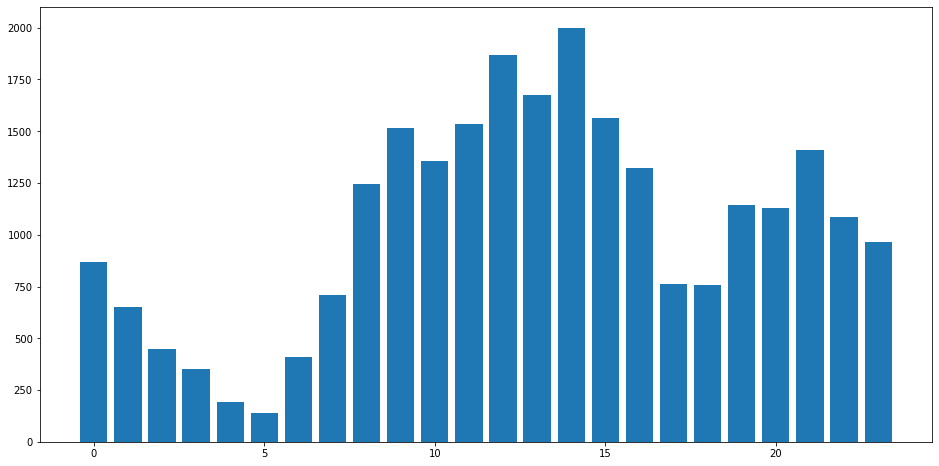

In [21]:
from datetime import datetime
import matplotlib.pyplot as plt
          
def getHourlyStreamingHistoryCount(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    hours[date.hour] += 1
  
  return hours

def getHourlyStreamingHistoryTime(time):
  hours = [0 for y in range(24)]
  
  for t in time:
    date = datetime.strptime(t[0], '%Y-%m-%d %H:%M')
    sec = t[4] / 1000 #seconds played
    min = sec / 60 #minute played
    hours[date.hour] += min
  
  return hours

def plotHourlyStreamingHistory(hours):
  y = [y for y in range(24)]
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

modern_rock_hourly_history = getHourlyStreamingHistoryTime(modern_rock_streaming_history)
plotHourlyStreamingHistory(modern_rock_hourly_history)

Let's compare that to metal

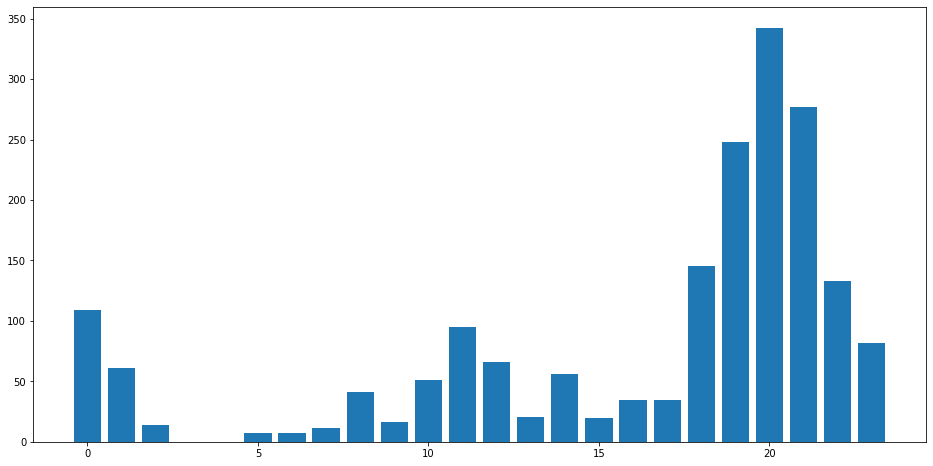

In [22]:
heavy_metal_streaming_history = getGenreStreamingHistory("metal")
heavy_metal_hourly_history = getHourlyStreamingHistoryTime(heavy_metal_streaming_history)
plotHourlyStreamingHistory(heavy_metal_hourly_history)

To be able to better compare what's going on, let's look at which are the most popular genres and then plot them against each other.

In [23]:
cmd = """ SELECT genreName, SUM(msPlayed)/(60*1000) FROM
          (
          SELECT artist_genres.genreName, streaming_history.trackName, streaming_history.msPlayed
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName
          )
          GROUP BY genreName
          ORDER BY SUM(msPlayed) DESC;
          """


cur = database.execute(cmd)
res = cur.fetchall()
print("So my most popular streamed genres:")
for i in range(50):
  print(res[i][0] + " : " + str(res[i][1]) + " min")

So my most popular streamed genres:
rock : 31752 min
modern rock : 25099 min
pop : 24104 min
electropop : 13362 min
classic rock : 12931 min
indie poptimism : 10804 min
tropical house : 10609 min
album rock : 10140 min
french indie pop : 9266 min
dance pop : 9179 min
pop rock : 8915 min
edm : 8468 min
permanent wave : 8173 min
art rock : 8152 min
modern alternative rock : 7864 min
pop dance : 7558 min
alternative rock : 7541 min
mellow gold : 7196 min
new french touch : 7067 min
french indietronica : 6888 min
pop rap : 6681 min
soft rock : 6622 min
indie pop : 6491 min
lancaster pa indie : 5780 min
progressive rock : 5693 min
electro house : 5072 min
hard rock : 4749 min
post-teen pop : 4407 min
alternative metal : 4396 min
piano rock : 4379 min
glam rock : 4246 min
electronica : 3928 min
stomp and holler : 3889 min
indie rock : 3821 min
progressive house : 3519 min
ohio hip hop : 3285 min
indietronica : 3195 min
psychedelic rock : 3130 min
rap : 3077 min
nu metal : 2758 min
hip hop : 

Let's look at that on a pie plot.

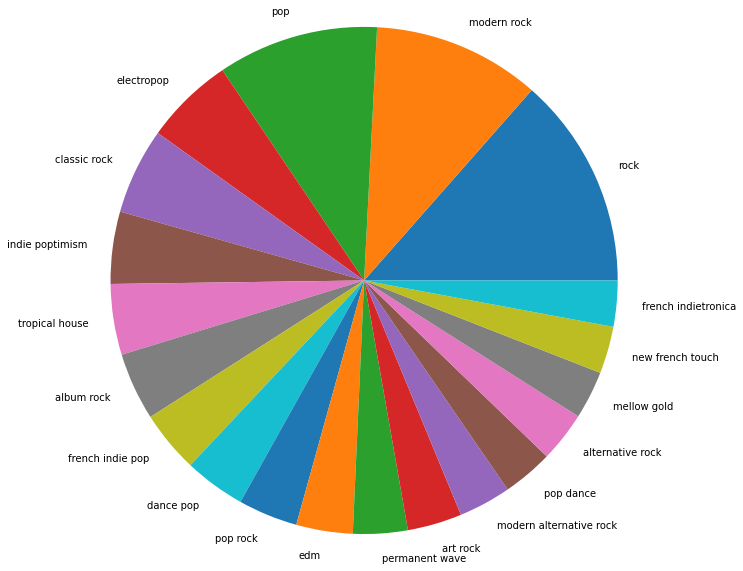

In [24]:
labels = []
sizes = []

for i in range(20):
  labels.append(res[i][0])
  sizes.append(res[i][1])

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels)
ax.axis('equal')

plt.show()

Let's take some different genres.

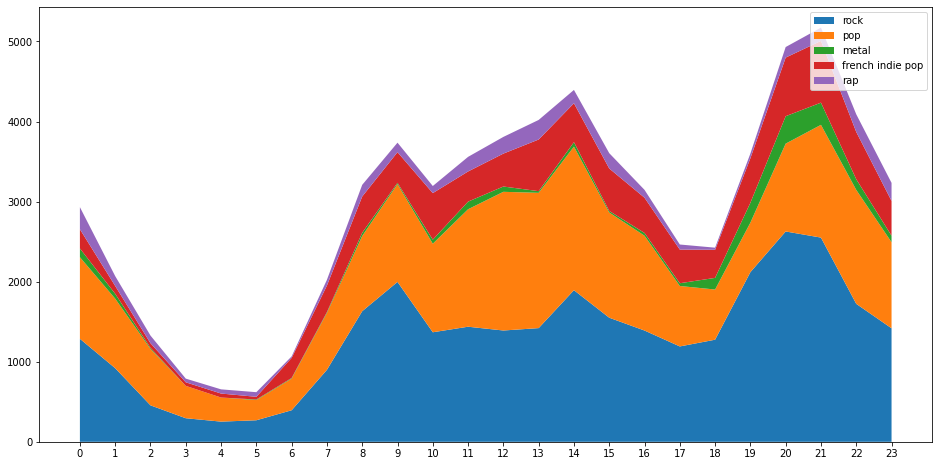

In [25]:
labels = [str(y) for y in range(24)]
genres = ["rock", "pop", "metal", "french indie pop", "rap"]
fig, ax = plt.subplots(figsize=(16, 8))

hours = {}

for genre in genres:
  hourly = getHourlyStreamingHistoryTime(getGenreStreamingHistory(genre))
  hours[genre] = hourly

ax.stackplot(labels, hours.values(),
             labels=hours.keys())

ax.legend()
plt.show()

In [ ]:
#close
database.close()

# Playlist analysis

In [26]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [28]:
print(tracks[21]["track"])

{'album': {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0r0KdmVS1Er3kaFnl1KPog'}, 'href': 'https://api.spotify.com/v1/artists/0r0KdmVS1Er3kaFnl1KPog', 'id': '0r0KdmVS1Er3kaFnl1KPog', 'name': 'Kwabs', 'type': 'artist', 'uri': 'spotify:artist:0r0KdmVS1Er3kaFnl1KPog'}], 'available_markets': ['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BN', 'BO', 'BR', 'BS', 'BW', 'BY', 'BZ', 'CH', 'CI', 'CL', 'CM', 'CO', 'CR', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FM', 'FR', 'GA', 'GD', 'GH', 'GM', 'GN', 'GQ', 'GR', 'GT', 'GW', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KM', 'KN', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LC', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MG', 'MK', 'ML', 'MN', 'MO', 'MR', 'MT', 'MU', 'MW', 'MY', 'MZ', 'NA', 'NE', 'NG', 'NI', 'N

Let's make a database with the tracks on my playlist. (id, name)

In [29]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS shazam_tracks(
                    trackId varchar(40),
                    trackName varchar(40),
                    artistName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [30]:
for track in tracks:
    id = track["track"]["id"]
    name = track["track"]["name"]
    artistName = track["track"]["artists"][0]["name"]
    values = [id, name, artistName]

    cmd = """INSERT INTO shazam_tracks VALUES(?, ?, ?, null);"""
    
    database.execute(cmd, values)

database.commit()

In [31]:
cmd = """SELECT * FROM shazam_tracks LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('5VQU5JJ857w83VUceyt6b9', 'Make Me Fade - Audiotree Live Version', 'K.Flay', 1)
('5KcYtdjhsQrNNMjJOSAUEz', 'Team', 'Lorde', 2)
('4GylZDT7adqIfVoPHyFb5X', 'Speeding Cars', 'Walking On Cars', 3)
('4b30rxe4kxjNl8YpE17Sew', 'Man on a Wire', 'The Script', 4)
('37sINbJZcFdHFAsVNsPq1i', 'Superheroes', 'The Script', 5)


Now let's get the features of the tracks.

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

track_features = get_tracks_features(tracks)

Now let's add the features to a new table

In [33]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS track_features(
                    danceability FLOAT(4),
                    energy FLOAT(4),
                    key INTEGER,
                    loudness DECIMAL(4, 4),
                    speechiness FLOAT(4),
                    acousticness FLOAT(4),
                    instrumentalness FLOAT(4),
                    liveness FLOAT(4),
                    valence FLOAT(4),
                    tempo DECIMAL(4, 4),
                    trackId varchar(40),
                    duration_ms BIGINT,
                    time_signature INTEGER,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")

database.commit()

In [34]:
keys = ["danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "id", "duration_ms", "time_signature"]

for item in track_features:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO track_features VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

[Text(0, 0, 'danceability'),
 Text(0, 0, 'energy'),
 Text(0, 0, 'speechiness'),
 Text(0, 0, 'acousticness'),
 Text(0, 0, 'instrumentalness'),
 Text(0, 0, 'liveness'),
 Text(0, 0, 'valence')]

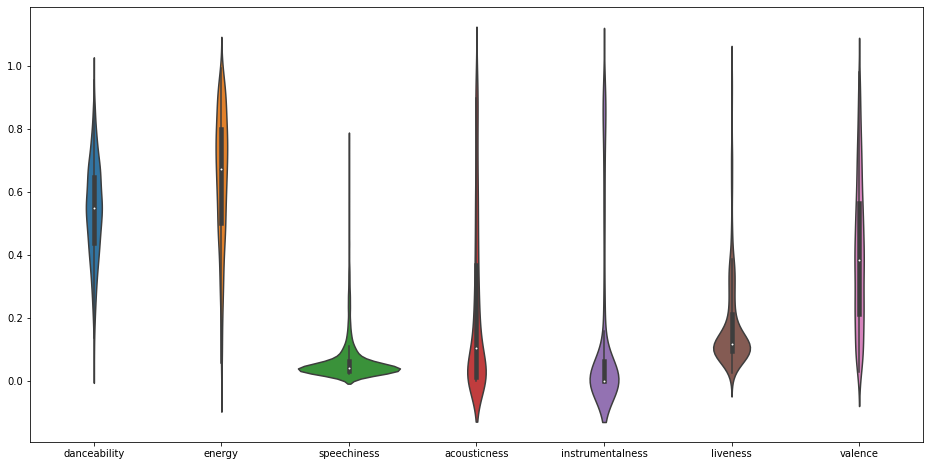

In [59]:
import numpy as np
import seaborn as sns

keys = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
cmd = "SELECT " + ", ".join(keys) + " FROM track_features;"
cur = database.execute(cmd)
res = cur.fetchall()

features = []
for i in range(7):
  feature = [x[i] for x in res]
  features.append(feature)

fig, ax = plt.subplots(figsize=(16, 8))
s = sns.violinplot(data=features, ax=ax)
s.set_xticklabels(keys)

In [37]:
genres = ["rock", "pop", "metal", "french indie pop", "rap"]
colors = ["red", "blue", "black", "yellow", "brown"]

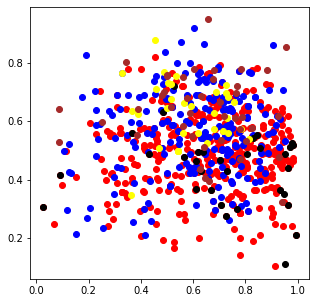

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(genres)):
  cmd = """ SELECT energy, danceability FROM shazam_tracks AS s
            INNER JOIN artist_genres AS a
            ON s.artistName=a.artistName
            INNER JOIN track_features AS t
            ON s.trackId=t.trackId
            WHERE genreName='""" + genres[i] + "';"

  cur = database.execute(cmd)
  res = cur.fetchall()

  features = []
  for j in range(2):
    feature = [x[j] for x in res]
    features.append(feature)

  ax.scatter(features[0], features[1], c=colors[i]);